# Evaluate melt rates (circumpolar and Amundsen Sea)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.plots import circumpolar_plot, finished_plot
from nemo_python_git.constants import rho_ice, sec_per_year, sec_per_day

In [26]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_folder    = f'{base_dir}output/ERA5_eddy_diff_up/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20240305.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20240305.nc'

In [27]:
def mask_land(nemo_mesh, file_var):
    mask = (nemo_mesh.tmask.isel(nav_lev=0) != 0) | (nemo_mesh.misf == 0)
    lon_plot = np.ma.masked_where(mask, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(mask, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(mask, file_var.values)
    return lon_plot, lat_plot, plot_var 

def plot_land(nemo_mesh, file_var):
    mask = (nemo_mesh.misf!=0) 
    lon_plot = np.ma.masked_where(mask, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(mask, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(mask, file_var.values)
    return lon_plot, lat_plot, plot_var 

## Ice shelf melt rates

In [28]:
nemo_mesh_ds = xr.open_dataset(nemo_mesh).isel(time_counter=0)
mesh_sub  = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350))

#### Amundsen Sea

In [29]:
from calendar import monthrange

# load nemo simulations
gridT_files = glob.glob(f'{run_folder}files/*SBC*')
nemo_ds     = xr.open_mfdataset(gridT_files) # load all the gridT files in the run folder
# nemo_ds   = xr.open_dataset(gridT_files[0])
days_per_month = [monthrange(nemo_ds.time_counter.dt.year[i].values, nemo_ds.time_counter.dt.month[i].values)[1] for i in range(0,nemo_ds.time_counter.size)]
nemo_ds   = nemo_ds.assign({'days_per_month':(('time_counter'), days_per_month)})
melt_rate = ((nemo_ds.fwfisf)*nemo_ds['days_per_month']*sec_per_day).sum(dim='time_counter')/(rho_ice*len(np.unique(nemo_ds.time_counter.dt.year)))

In [30]:
melt_rate_sub = melt_rate.isel(x_grid_T=slice(450, 900), y_grid_T=slice(130,350))

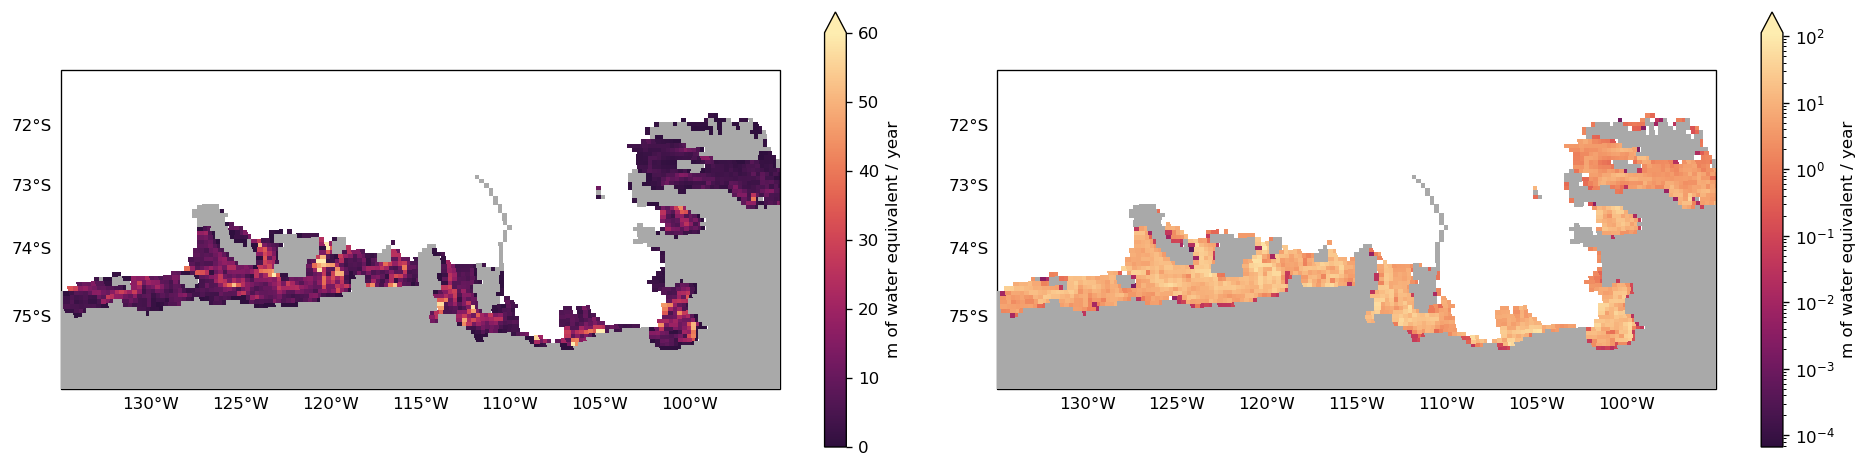

In [9]:
# Check that the observations depth is close enough to the bottom bathymetry to be considered representative

# Select the NEMO variables we need and time-average    
lon_land, lat_land, land_plt = plot_land(mesh_sub, mesh_sub.bathy_metry)

#------------- Plot figure -----------------
fig, ax = plt.subplots(1,2, figsize=(16,4), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=120)

lon_plt, lat_plt, var_plt = mask_land(mesh_sub, melt_rate_sub)
img1 = ax[0].pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, 
                     vmin=0, vmax=60, cmap=cmocean.cm.matter_r)

img2 = ax[1].pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, 
                    cmap=cmocean.cm.matter_r, norm=cl.LogNorm())
img = [img1, img2]
for n, axis in enumerate(ax.ravel()):
    axis.set_extent([-95, -135, -76, -71], ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

    axis.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, 
              cmap=cl.ListedColormap(['DarkGrey']), zorder=3)
    
    plt.colorbar(img[n], ax=axis, extend='max', label='m of water equivalent / year')

plt.tight_layout()

## Circumpolar Antarctic

vmin and vmax must be positive and non-zero when using a logarithmic colormap (lognorm=True), so allowing pcolormesh to choose limits instead


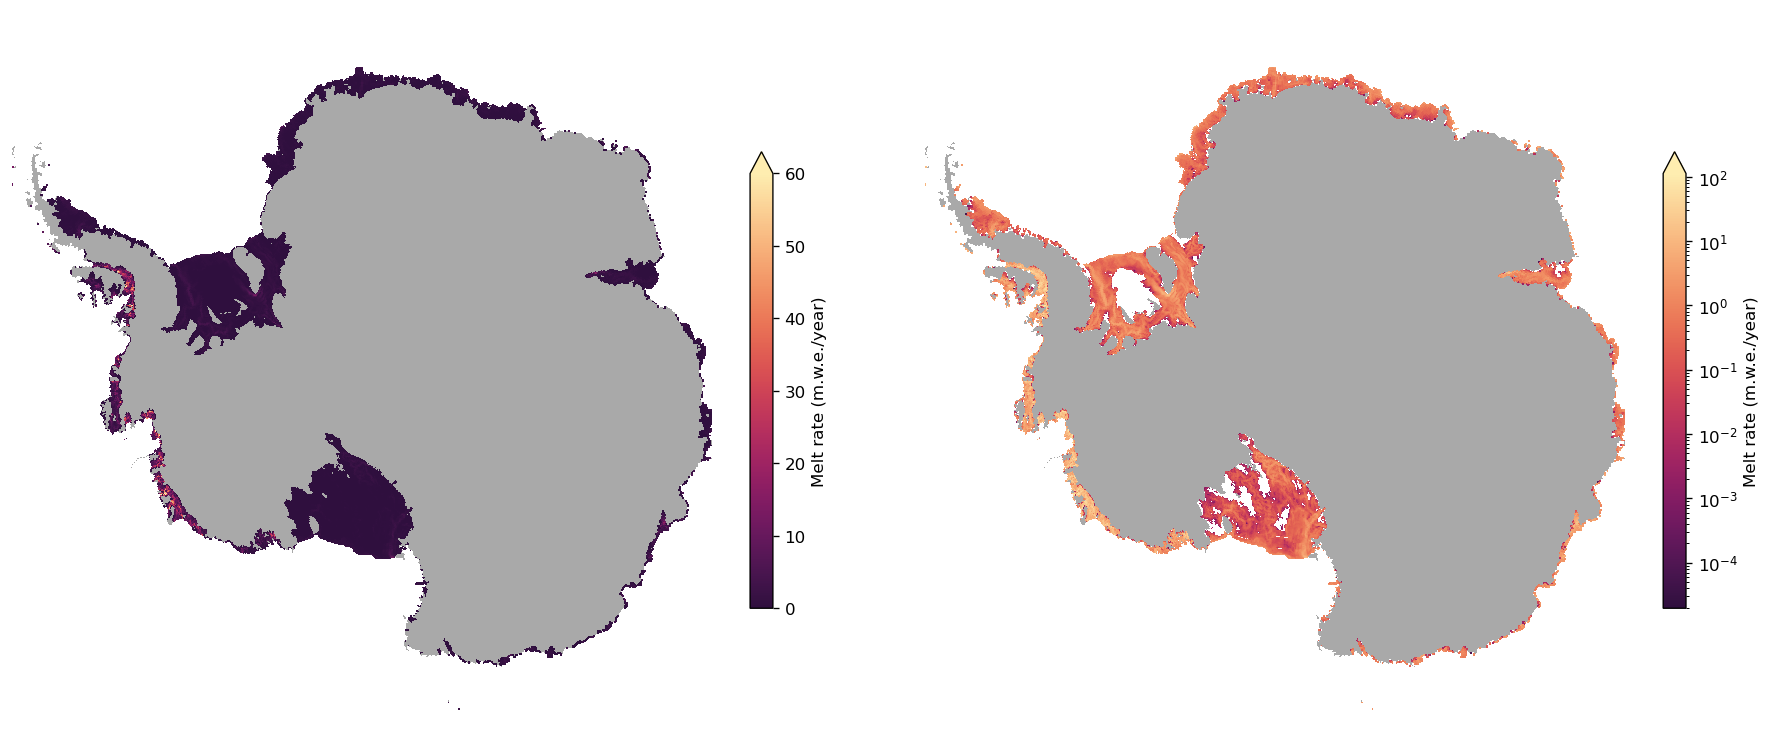

In [8]:
fig, ax = plt.subplots(1,2, figsize=(18,8), dpi=120)

img1 = circumpolar_plot(melt_rate, nemo_mesh_ds, ax=ax[0], masked=False, make_cbar=False, title='',
                        vmin=0, vmax=60, ctype=cmocean.cm.matter_r, shade_land=True, lat_max=-66)

img2 = circumpolar_plot(melt_rate, nemo_mesh_ds, ax=ax[1], masked=False, make_cbar=False, title='',
                        lognorm=True, ctype=cmocean.cm.matter_r, shade_land=True, lat_max=-66)

img = [img1, img2]
for n, axis in enumerate(ax.ravel()):
    plt.colorbar(img[n], ax=axis, extend='max', label='Melt rate (m.w.e./year)', fraction=0.03)

## Calculate total melt over time (gigatonnes)

In [31]:
annual_melt_rate = ((nemo_ds.area_grid_T*nemo_ds.fwfisf)*nemo_ds['days_per_month']*sec_per_day).resample(time_counter='Y').sum()*1e-12 # kg/m2/s --> kg/s

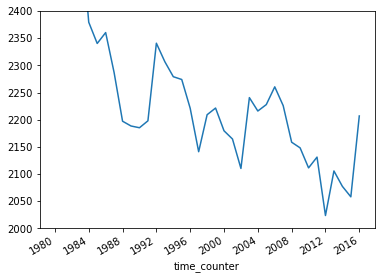

In [35]:
annual_melt_rate.sum(dim=['x_grid_T','y_grid_T']).plot(ylim=(2000,2400))

# Combine into a generalized plot that does everything

In [ ]:
# Check that the observations depth is close enough to the bottom bathymetry to be considered representative

# Select the NEMO variables we need and time-average    
lon_land, lat_land, land_plt = plot_land(mesh_sub, mesh_sub.bathy_metry)

#------------- Plot figure -----------------
fig, ax = plt.subplots(1,2, figsize=(10,4), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=120)

ax.set_extent([-95, -135, -76, -71], ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True);
gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

# kg/m2/s / kg/m3 --> m/s *sec_per_year --> m / year
lon_plt, lat_plt, var_plt = mask_land(mesh_sub, melt_rate_sub)
img = ax.pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, vmin=0, vmax=60, cmap=cmocean.cm.matter_r)
ax.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cl.ListedColormap(['DarkGrey']), zorder=3)
plt.colorbar(img, ax=ax, extend='max', label='m of water equivalent / year')